<table style="width: 100%;" id="nb-header">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2021<br>
            Dr. Eric Van Dusen <br>
        Alan Liang, Umar Maniku <br>
</table>

# Lecture 10: Macroeconomics Policy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datascience import * 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import curve_fit
import math
from math import *
import seaborn as sns
import itertools
%matplotlib inline

In [2]:
gdp = pd.read_csv("real_gdp_over_time.csv")
gdp_growth = pd.read_csv("real_growth_over_time.csv")
inflation = pd.read_csv("inflation_over_time.csv")
unemployment = pd.read_csv("unemployment_over_time.csv")
deficit = pd.read_csv("deficit_over_time.csv")
ffr = pd.read_csv("fedfunds.csv")
potential_gdp = pd.read_csv("potential_gdp.csv")
unemployment_gap = pd.read_csv("nrou.csv")
core_inflation = pd.read_csv("core_inflation.csv")
core_inflation["CPILFESL_PC1"] = core_inflation["CPILFESL_PC1"].apply(lambda item: np.round(float(item), 2))

gdp = gdp.set_index("DATE")
gdp_growth = gdp_growth.set_index("DATE")
inflation = inflation.set_index("DATE")
core_inflation = core_inflation.set_index("DATE")
unemployment = unemployment.set_index("DATE")
deficit = deficit.set_index("DATE")
ffr = ffr.set_index("DATE")
unemployment_gap = unemployment_gap.set_index("DATE")
potential_gdp = potential_gdp.set_index("DATE")

macroeconomics = gdp.merge(gdp_growth, left_index = True, right_index = True)\
                    .merge(inflation, left_index = True, right_index = True)\
                    .merge(unemployment, left_index = True, right_index = True)\
                    .merge(ffr, left_index = True, right_index = True)\
                    .merge(unemployment_gap, left_index = True, right_index = True)\
                    .merge(core_inflation, left_index = True, right_index = True)

del gdp
del gdp_growth
del inflation
del unemployment
del unemployment_gap
del core_inflation

potential_gdp = potential_gdp[potential_gdp.index <= max(macroeconomics.index)]

In [3]:
macroeconomics.head()

GDP  GDP_GROWTH  INFLATION  UNEMPLOYMENT  FEDFUNDS      NROU  \
DATE                                                                            
1958-01-01  2906.274    -2.87228    2.80702           5.8      2.72  5.414240   
1958-04-01  2925.379    -2.01912    2.43056           7.4      1.26  5.418266   
1958-07-01  2993.068    -0.72476    2.06897           7.5      0.68  5.422658   
1958-10-01  3063.085     2.65969    1.71233           6.7      1.80  5.427429   
1959-01-01  3121.936     7.42057    2.04778           6.0      2.48  5.432577   

            CPILFESL_PC1  
DATE                      
1958-01-01          2.80  
1958-04-01          2.43  
1958-07-01          2.07  
1958-10-01          1.82  
1959-01-01          1.81

---

## Time series: 1958 to present

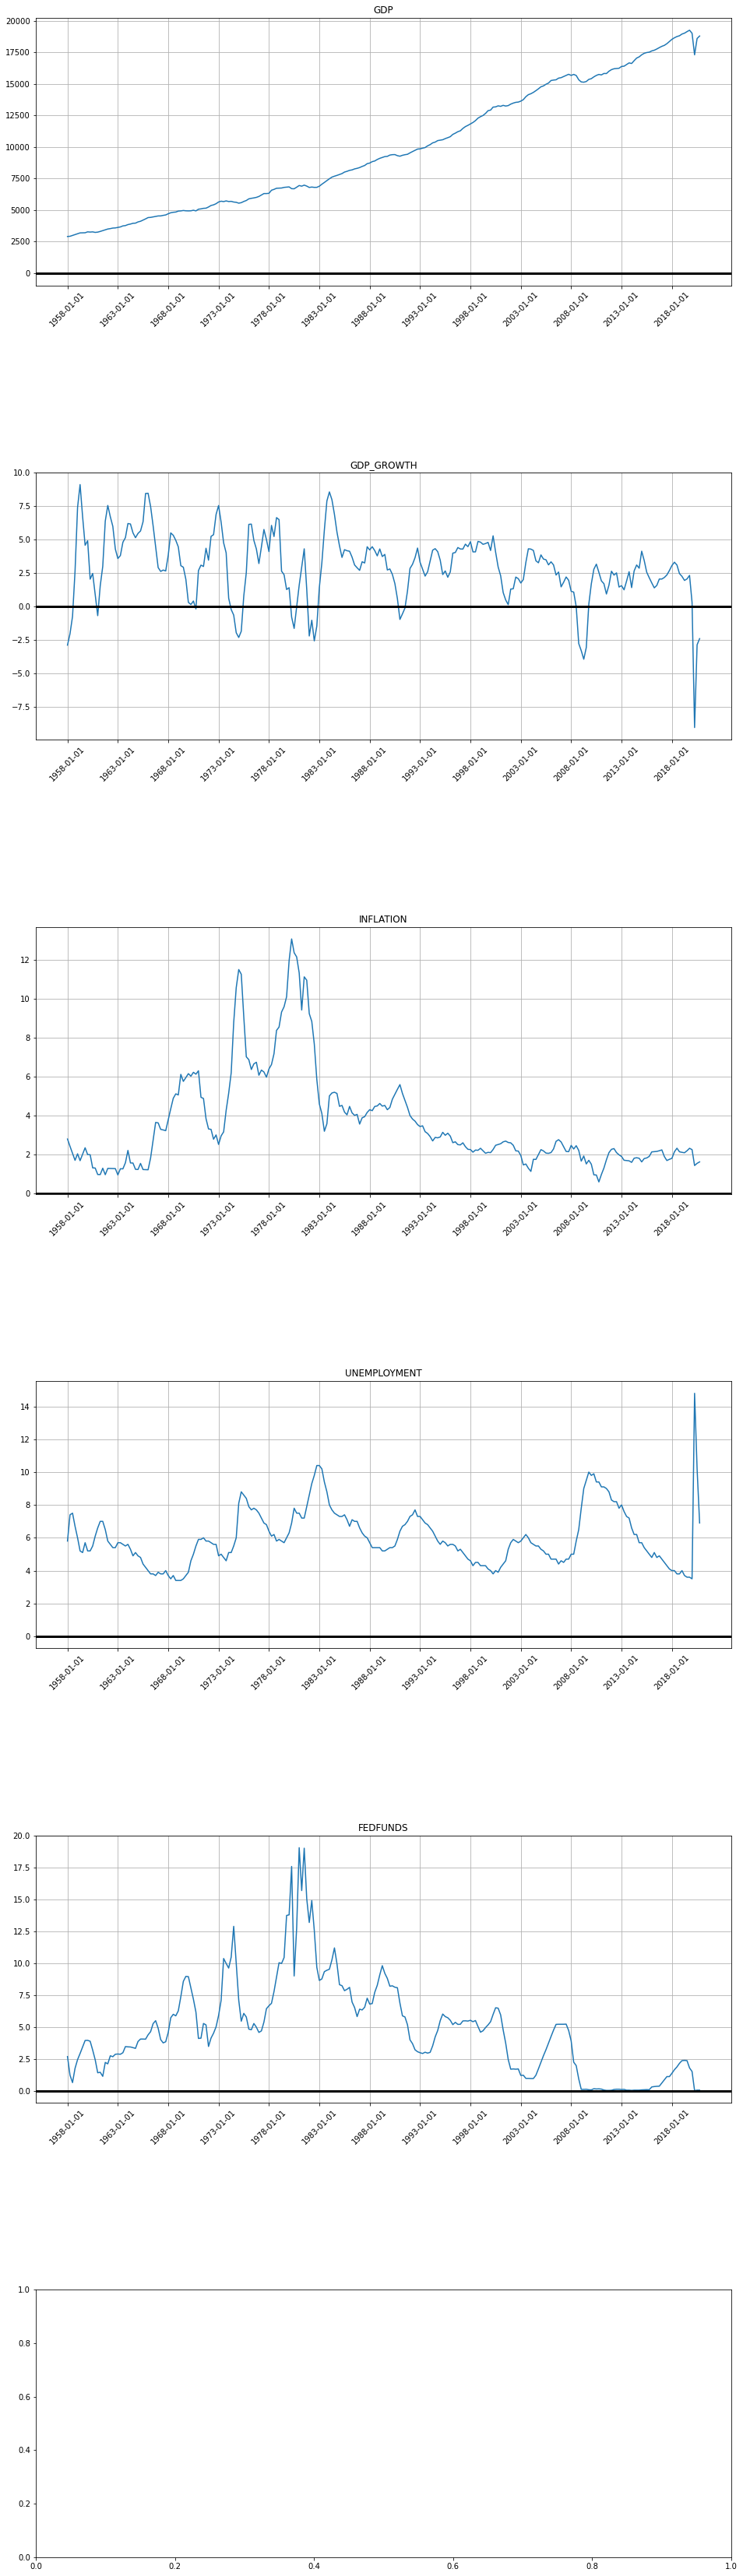

In [4]:
fig, ax = plt.subplots(6, 1)
for axe, col in zip(ax.flatten(), list(macroeconomics.columns) + ["DEFICIT"]):
    if col == "DEFICIT":
        axe.plot(deficit.index, deficit.DEFICIT)
        axe.set_xticks(np.arange(0, deficit.shape[0], 5))
        axe.set_xticklabels(deficit.index[np.arange(0, deficit.shape[0], 5)], rotation=45)
        axe.set_title(col)
        axe.grid()
        axe.axhline(color="black", linewidth=3)
    elif col == "NROU":
        continue
    else:
        axe.plot(macroeconomics.index, macroeconomics[col])
        axe.set_xticks(np.arange(0, macroeconomics.shape[0], 20))
        axe.set_xticklabels(macroeconomics.index[np.arange(0, macroeconomics.shape[0], 20)], rotation=45)
        axe.set_title(col)
        axe.grid()
        axe.axhline(color="black", linewidth=3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)
fig.set_size_inches(16, 60)

## Macroeconomic Indicators during the pandemic

In [5]:
covid = macroeconomics[macroeconomics.index >= "2019-01-01"]
covid_deficit = deficit[deficit.index >= "2019-01-01"]
covid_potential_gdp = potential_gdp[potential_gdp.index >= "2019-01-01"]
covid_ffr = ffr[ffr.index >= "2019-01-01"]

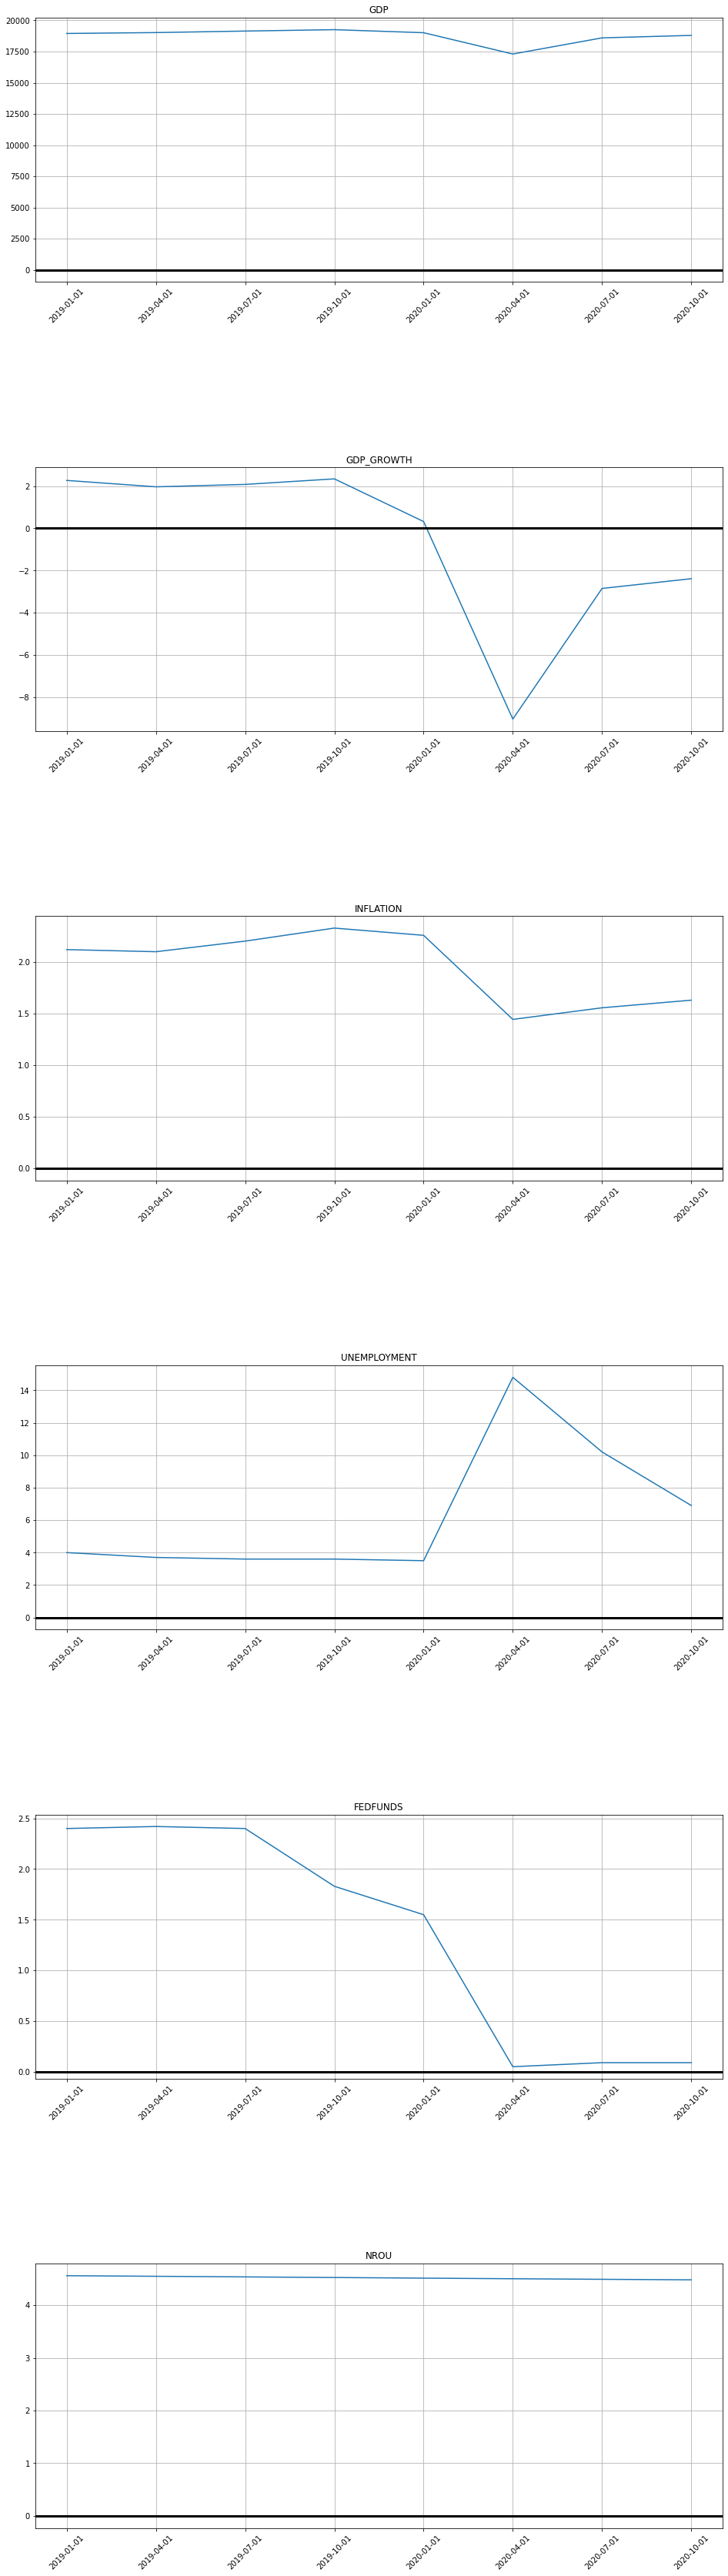

In [6]:
fig, ax = plt.subplots(6, 1)
for axe, col in zip(ax.flatten(), list(covid.columns) + ["DEFICIT"]):
    if col == "DEFICIT":
        axe.plot(covid_deficit.index, covid_deficit.DEFICIT)
        axe.set_xticks(covid_deficit.index)
        axe.set_xticklabels(covid_deficit.index, rotation=45)
        axe.set_title(col)
        axe.grid()
        axe.axhline(color="black", linewidth=3)
    else:
        axe.plot(covid.index, covid[col])
        axe.set_xticks(covid.index)
        axe.set_xticklabels(covid.index, rotation=45)
        axe.set_title(col)
        axe.grid()
        axe.axhline(color="black", linewidth=3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)
fig.set_size_inches(16, 60)

---

### Phillips Curve: A negative relationship between inflation and unemployment
$$ \pi = -f(u)$$

In [7]:
def year_grouper(row, base):
    """
    2020 does not have enough data points, so making 1 big 2000s group
    """
    date = int(row.name[0:4])
    if date >= 2020:
        date -= base
    return base * round(math.floor(date / base))

In [8]:
phillips_curve = macroeconomics.loc[:, ["UNEMPLOYMENT", "CPILFESL_PC1", "NROU"]]
phillips_curve["Year Group"] = phillips_curve.apply(lambda item: year_grouper(item, 10), axis=1)
phillips_curve.head()

UNEMPLOYMENT  CPILFESL_PC1      NROU  Year Group
DATE                                                        
1958-01-01           5.8          2.80  5.414240        1950
1958-04-01           7.4          2.43  5.418266        1950
1958-07-01           7.5          2.07  5.422658        1950
1958-10-01           6.7          1.82  5.427429        1950
1959-01-01           6.0          1.81  5.432577        1950

In [9]:
unique_vals = pd.DataFrame([[k,v.values] for k,v in phillips_curve.groupby('UNEMPLOYMENT').groups.items()], 
                      columns=['UNEMPLOYMENT','indices'])
unique_vals["indices"] = unique_vals["indices"].apply(lambda item: item[0])
unique_vals["CPILFESL_PC1"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "CPILFESL_PC1"])
unique_vals["NROU"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "NROU"])
unique_vals["Year Group"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "Year Group"])
unique_vals.set_index("indices", inplace=True)
unique_vals.head()

UNEMPLOYMENT  CPILFESL_PC1      NROU  Year Group
indices                                                     
1968-10-01           3.4          5.20  5.826905        1960
1968-04-01           3.5          4.44  5.803658        1960
2019-07-01           3.6          2.30  4.536518        2010
1966-10-01           3.7          3.44  5.734915        1960
1966-04-01           3.8          2.14  5.710529        1960

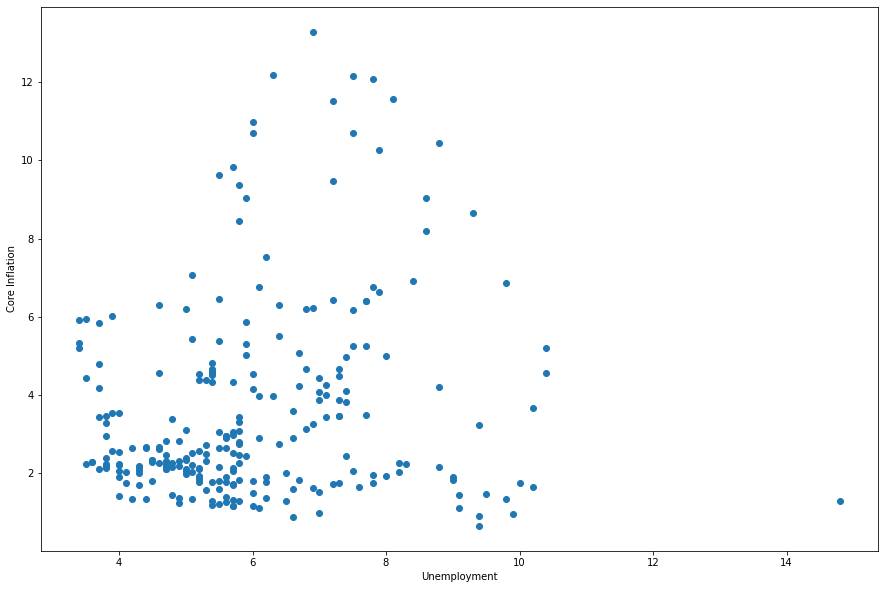

In [10]:
plt.figure(figsize=(15, 10))
plt.scatter(x=phillips_curve["UNEMPLOYMENT"], y=phillips_curve["CPILFESL_PC1"])
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.show()

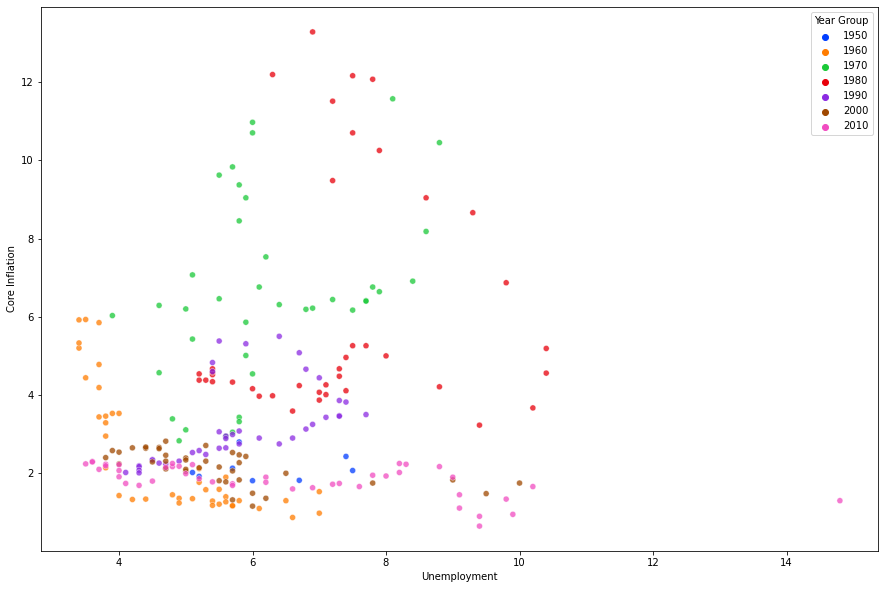

In [11]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x="UNEMPLOYMENT", y="CPILFESL_PC1", data=phillips_curve, 
                hue="Year Group", palette="bright", alpha=0.75)
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.show()

### What do you notice about the relationship between unemployment and inflation over time?

In [12]:
def aesthetic_pc(x, a):
    return a / x

In [13]:
popt, _ = curve_fit(aesthetic_pc, unique_vals["UNEMPLOYMENT"], unique_vals["CPILFESL_PC1"])

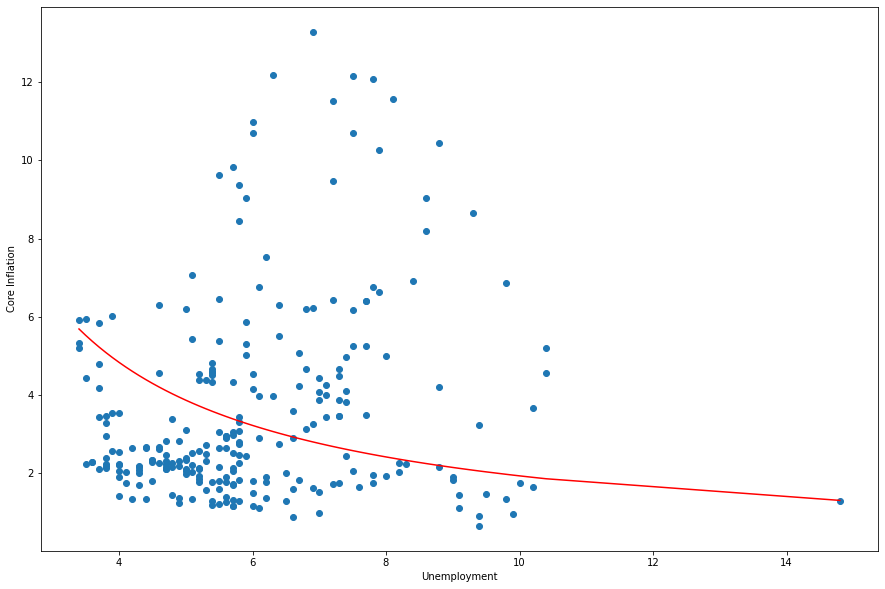

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(unique_vals["UNEMPLOYMENT"], aesthetic_pc(unique_vals["UNEMPLOYMENT"], *popt), color="red")
plt.scatter(x=phillips_curve["UNEMPLOYMENT"], y=phillips_curve["CPILFESL_PC1"])
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.show()

### Expectations-adjusted Phillips Curve
$$
\pi - \pi^e = - \beta \left (u - u^* \right ) + ss
$$

Note: FRED doesn't have data for inflation expectations earlier than 1978. We will use the Feb 2021 number of 3.3%.

In [15]:
def pc(unemployment_gap, beta=0.5, price_shock=0):
    """
    Equation forces -beta to get negative relationship
    """
    beta = -abs(beta)
    return beta * unemployment_gap + price_shock

In [16]:
popt, _ = curve_fit(pc, unique_vals["UNEMPLOYMENT"] - unique_vals["NROU"], unique_vals["CPILFESL_PC1"] - 3.3)

In [17]:
x_vals = np.linspace(min(phillips_curve["UNEMPLOYMENT"] - phillips_curve["NROU"]), 
                     max(phillips_curve["UNEMPLOYMENT"] - phillips_curve["NROU"]),
                     40)

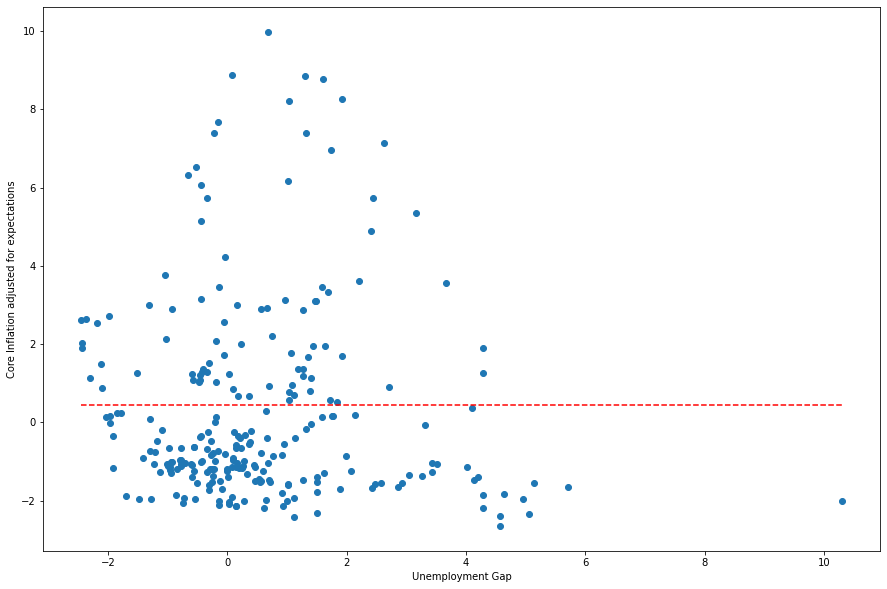

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(x_vals, pc(x_vals, *popt), "r--")
plt.scatter(x=phillips_curve["UNEMPLOYMENT"] - phillips_curve["NROU"], 
            y=phillips_curve["CPILFESL_PC1"] - 3.3)
plt.xlabel("Unemployment Gap")
plt.ylabel("Core Inflation adjusted for expectations")
plt.show()

### Expectations-adjusted Phillips Curve for different year groups

In [19]:
palette = itertools.cycle(sns.color_palette("bright"))
year_groups = unique_vals["Year Group"].value_counts().index.values
year_groups.sort()
params = {}
colors = {}
for year in year_groups:
    curr_year_group = phillips_curve[phillips_curve["Year Group"] == year]
    params[year], _ = curve_fit(pc, curr_year_group["UNEMPLOYMENT"] - curr_year_group["NROU"], 
                                curr_year_group["CPILFESL_PC1"] - 3.3)
    colors[year] = next(palette)

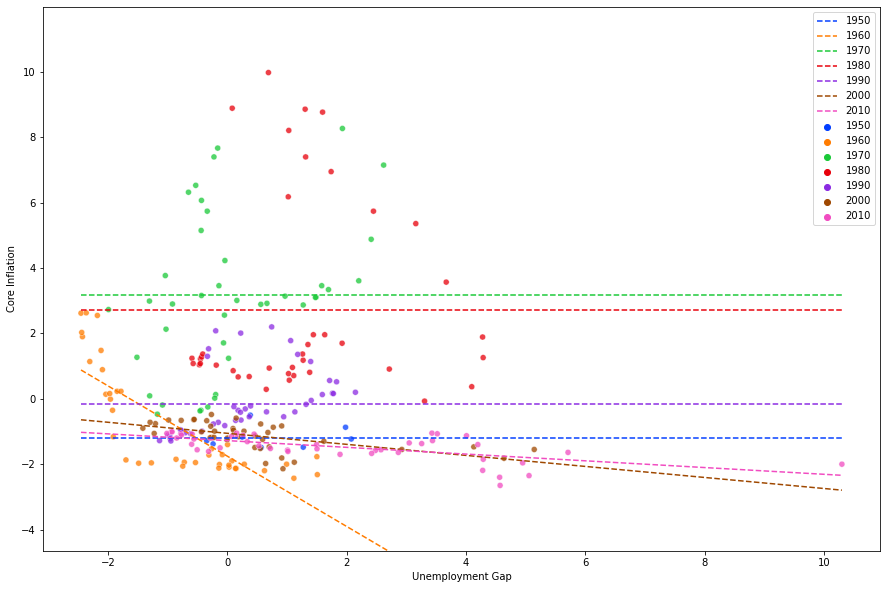

In [20]:
plt.figure(figsize=(15, 10))

for year in year_groups:
    plt.plot(x_vals, 
             pc(x_vals, *params[year]), 
             "--", 
             label=f"{year}", c=colors[year])
    
sns.scatterplot(x=phillips_curve["UNEMPLOYMENT"] - phillips_curve["NROU"], 
                y=phillips_curve["CPILFESL_PC1"] - 3.3, 
                data=phillips_curve, 
                hue="Year Group",
                palette=sns.color_palette("bright")[0:len(colors)],
                alpha=0.75)
plt.legend()
plt.xlabel("Unemployment Gap")
plt.ylabel("Core Inflation")
plt.ylim(min(phillips_curve["CPILFESL_PC1"] - 3.3) - 2, max(phillips_curve["CPILFESL_PC1"] - 3.3) + 2)
plt.show()

---

## Federal Funds Rate and The Taylor Rule: 1958 to Present

### Taylor Rule:
$$
r_{\text{predicted}} = r_{\text{target}} + \pi + \alpha \left ( \pi - \pi_{\text{target}} \right ) + \beta \left ( \dfrac{Y - Y^*}{Y^*} \right )
$$

In [21]:
def taylor_rule(interest_rate_target, inflation, inflation_target, output, potential_output, alpha=0.5, beta=0.5):
    return interest_rate_target + inflation + alpha * (inflation - inflation_target) + \
            beta * ((output - potential_output) / potential_output) * 100

In [22]:
def taylor_rule_plotter(arr, ffr_arr=None, label=None):
    plt.figure(figsize=(17, 9))
    if ffr_arr is not None:
        plt.plot(ffr_arr, label="FFR")
        plt.xticks(np.arange(0, ffr_arr.shape[0]), rotation=60)
    else:
        plt.plot(macroeconomics.loc[:, "FEDFUNDS"], label="FFR")
        plt.xticks(np.arange(0, ffr.shape[0], 20), rotation=60)
    plt.plot(arr, label=label)
    plt.legend()
    plt.grid()
    plt.axhline(color="black", linewidth=2)
    plt.show();

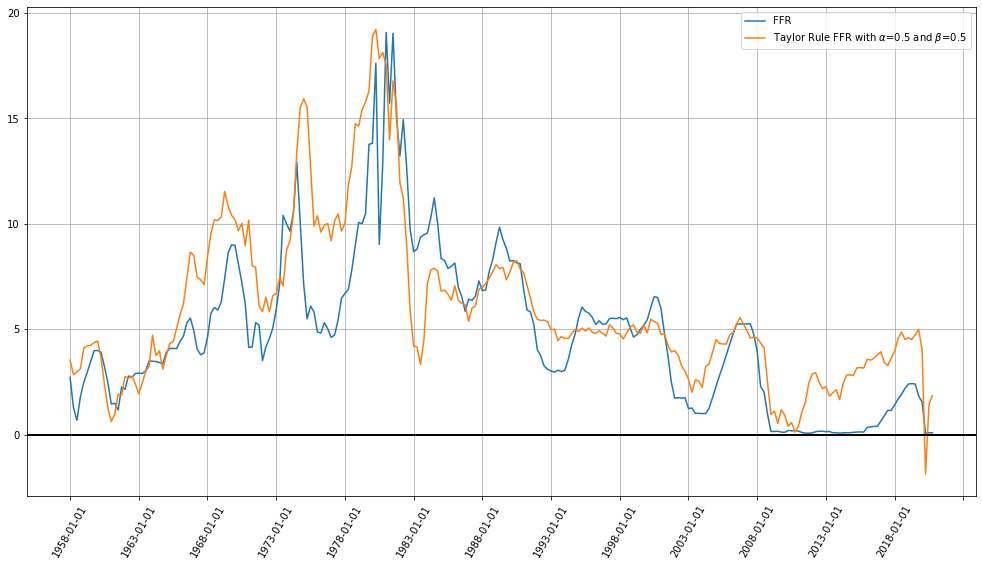

In [23]:
taylor_rule_preds = taylor_rule(2, macroeconomics.loc[:, "INFLATION"], 2, 
                                macroeconomics.loc[:, "GDP"], potential_gdp.loc[:, "GDPPOT"])

taylor_rule_plotter(taylor_rule_preds, label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")

## FFR and The Taylor Rule during the pandemic

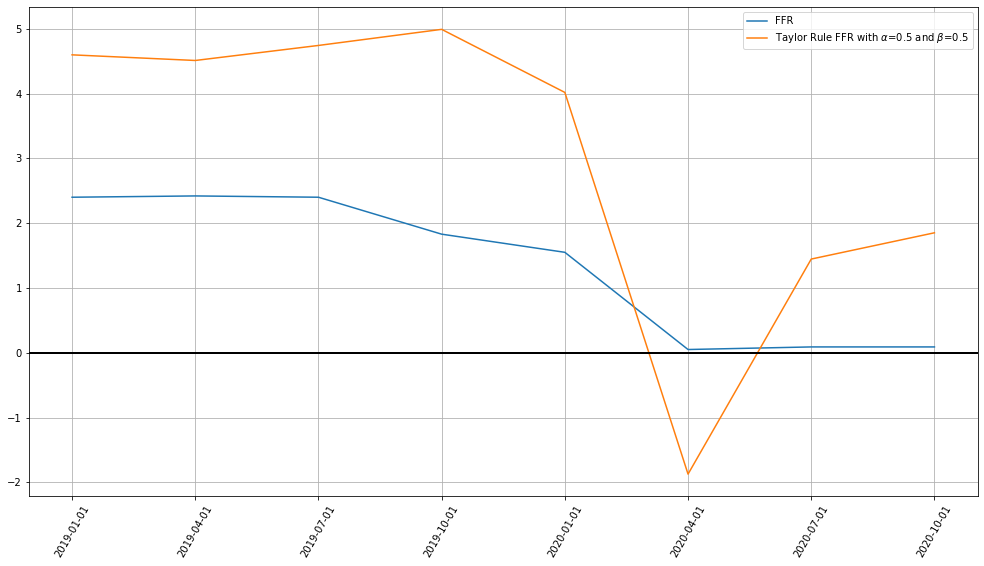

In [24]:
taylor_rule_preds_covid = taylor_rule(2, covid.loc[:, "INFLATION"], 2, 
                                covid.loc[:, "GDP"], covid_potential_gdp.loc[:, "GDPPOT"])

taylor_rule_plotter(taylor_rule_preds_covid, ffr_arr=covid.loc[:, "FEDFUNDS"], 
                    label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")

In [25]:
def taylor_rmse(alpha, beta):
    taylor_interest_rate = np.array(taylor_rule(2, macroeconomics.loc[:, "INFLATION"], 2, 
                                                macroeconomics.loc[:, "GDP"], potential_gdp.loc[:, "GDPPOT"], 
                                                alpha = alpha, beta = beta))
    actual_interest_rate = np.array(macroeconomics.FEDFUNDS)
    return np.mean(((taylor_interest_rate - actual_interest_rate) ** 2))

In [26]:
def taylor_widget(alpha, beta):
    rmse = taylor_rmse(alpha, beta)
    print(f"RMSE: {rmse}")
    taylor_rule_preds = taylor_rule(2, macroeconomics.loc[:, "INFLATION"], 2, 
                                macroeconomics.loc[:, "GDP"], potential_gdp.loc[:, "GDPPOT"], 
                                    alpha=alpha, beta=beta)
    taylor_rule_plotter(taylor_rule_preds, 
                        label=rf"Taylor Rule FFR with $\alpha$={alpha} and $\beta$={beta}");

### Taylor Rule:
$$
r_{\text{predicted}} = r_{\text{target}} + \pi + \alpha \left ( \pi - \pi_{\text{target}} \right ) + \beta \left ( \dfrac{Y - Y^*}{Y^*} \right )
$$

In [27]:
alpha_widget = widgets.FloatSlider(min=-1, max=2, step=0.01, value=0.5)
beta_widget = widgets.FloatSlider(min=-1, max=2, step=0.01, value=0.5)
interact(taylor_widget, alpha=alpha_widget, beta=beta_widget)

interactive(children=(FloatSlider(value=0.5, description='alpha', max=2.0, min=-1.0, step=0.01), FloatSlider(vâ€¦

<function __main__.taylor_widget(alpha, beta)>

## Optimizing for $\alpha$, $\beta$

In [28]:
alpha, beta = minimize(taylor_rmse)
print(f"RMSE using optimized parameters: {taylor_rmse(alpha, beta)}")
print(f"alpha: {alpha}, beta: {beta}")

RMSE using optimized parameters: 4.924795209129221
alpha: 0.06898452717852031, beta: 0.3723091428889343


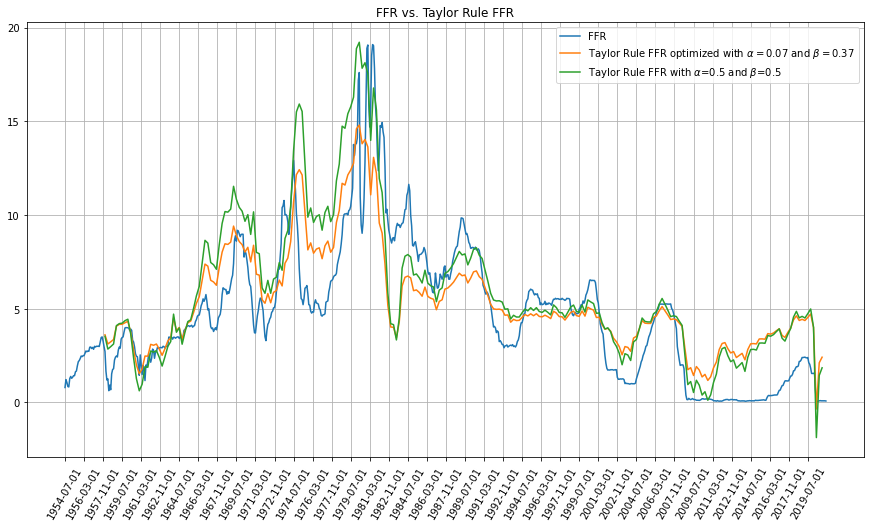

In [29]:
taylor_rule_preds = taylor_rule(2, macroeconomics.loc[:, "INFLATION"], 2, 
                                macroeconomics.loc[:, "GDP"], potential_gdp.loc[:, "GDPPOT"], 
                                alpha=alpha, beta=beta)
taylor_rule_preds_basic = taylor_rule(2, macroeconomics.loc[:, "INFLATION"], 2, 
                                      macroeconomics.loc[:, "GDP"], potential_gdp.loc[:, "GDPPOT"], 
                                      alpha=0.5, beta=0.5)

plt.figure(figsize=(15, 8))
plt.plot(ffr, label="FFR")
plt.plot(taylor_rule_preds, label=fr"Taylor Rule FFR optimized with $\alpha={np.round(alpha, 2)}$ and $\beta={np.round(beta, 2)}$")
plt.plot(taylor_rule_preds_basic, label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")
plt.xticks(rotation=45)
plt.xticks(np.arange(0, ffr.shape[0], 20), rotation=60)
plt.legend()
plt.grid()
plt.title("FFR vs. Taylor Rule FFR")
plt.show();